### Data Preprocessing
In this notebook, we will be working with a dataset of 10000 samples, each with 9 features. We will be using data preprocessing techniques to clean and transform the data. 
We will be using the following techniques:
- Encoding categorical variables
- Scaling/normalizing the data
- Dimensionality reduction
### Importing Libraries and Loading Data

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
import umap

import warnings
warnings.filterwarnings('ignore')

In [13]:
data = pd.read_csv('Data_Preprocessed/data_clean.csv')
data.head()

,Age,Gender,Blood Type,Medical Condition,Insurance Provider,Billing Amount,Admission Type,Medication,Test Results
0,81,Female,O-,Diabetes,Medicare,37490.98336,Elective,Aspirin,Inconclusive
1,35,Male,O+,Asthma,UnitedHealthcare,47304.06485,Emergency,Lipitor,Normal
2,61,Male,B-,Obesity,Medicare,36874.89700,Emergency,Lipitor,Normal
3,49,Male,B-,Asthma,Medicare,23303.32209,Urgent,Penicillin,Abnormal
4,51,Male,O-,Arthritis,UnitedHealthcare,18086.34418,Urgent,Paracetamol,Normal


In [14]:
data.columns

Index(['Age', 'Gender', 'Blood Type', 'Medical Condition',
       'Insurance Provider', 'Billing Amount', 'Admission Type', 'Medication',
       'Test Results'],
      dtype='object')

### Data Preprocessing Pipeline

In [15]:
class OrdinalFeatureEncoder(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.ordinal_encoder = OrdinalEncoder(
            categories=[
                ['Elective', 'Emergency', 'Urgent'],
                ['Inconclusive', 'Normal', 'Abnormal']
            ]
        )

    def fit(self, X, y=None):
        self.ordinal_encoder.fit(X[['Admission Type', 'Test Results']])
        return self

    def transform(self, X):
        encoded_values = self.ordinal_encoder.transform(X[['Admission Type', 'Test Results']])
        X[['Admission Type Encoded', 'Test Results Encoded']] = encoded_values
        return X

In [16]:
class LabelFeatureEncoder(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.label_encoders = {}  # Dictionary to store LabelEncoders

    def fit(self, X, y=None):
        categorical_columns = ['Gender', 'Blood Type', 'Medical Condition', 'Insurance Provider', 'Medication']
        for col in categorical_columns:
            le = LabelEncoder()
            le.fit(X[col])
            self.label_encoders[col] = le  # Store fitted LabelEncoder
        return self

    def transform(self, X):
        for col in self.label_encoders:
            X[f'{col} encoded'] = self.label_encoders[col].transform(X[col])
        return X

In [17]:
class FeatureDropper(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(['Gender', 'Blood Type', 'Medical Condition', 'Insurance Provider', 'Medication', 'Admission Type', 'Test Results'], axis=1, errors="ignore")

In [18]:
class FeatureScaler(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        self.feature_names = X.drop(['Test Results Encoded'], axis=1).columns
        self.scaler.fit(X[self.feature_names])
        return self
    
    def transform(self, X):
        X[self.feature_names] = self.scaler.transform(X[self.feature_names])
        return pd.DataFrame(X, columns=X.columns, index=X.index) if isinstance(X, pd.DataFrame) else X

In [19]:
pipeline = Pipeline([
                ("OrdinalFeatureEncoder", OrdinalFeatureEncoder()),
                ("LabelFeatureEncoder", LabelFeatureEncoder()),
                ("FeatureDropper", FeatureDropper()),
                ("FeatureScaler", FeatureScaler())
            ])

### Dataset Splitting
We should split our dataset first before passing it to the preprocessing pipeline to prevent data leakage.

In [20]:
# First, split into train + temp (val + test)
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True, stratify=data['Test Results'])  

# Then, split temp into validation and test sets (50% of 30% = 15% each)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True, stratify=temp_data['Test Results'])

In [21]:
print(f"shape of training data: {train_data.shape}")
print(f"shape of validation data: {val_data.shape}")
print(f"shape of testing data: {test_data.shape}")

shape of training data: (8000, 9)
shape of validation data: (1000, 9)
shape of testing data: (1000, 9)


### Preprocess the Dataset

In [22]:
train_data_preprocessed = pipeline.fit_transform(train_data)
train_data_preprocessed.head()

,Age,Billing Amount,Admission Type Encoded,Test Results Encoded,Gender encoded,Blood Type encoded,Medical Condition encoded,Insurance Provider encoded,Medication encoded
5506,0.358209,0.220464,0.0,1.0,0.0,0.571429,0.0,0.75,1.00
8675,0.925373,0.945664,0.5,0.0,1.0,0.571429,0.8,1.00,0.50
9016,0.119403,0.438802,1.0,0.0,1.0,0.142857,0.4,0.50,0.75
8393,0.000000,0.754759,0.5,2.0,0.0,0.142857,0.4,0.50,0.50
3854,0.731343,0.348147,1.0,1.0,1.0,0.714286,0.6,0.50,0.00


In [23]:
val_data_preprocessed = pipeline.transform(val_data)
test_data_preprocessed = pipeline.transform(test_data)

In [24]:
data_preprocessed = pipeline.transform(data)

### Correlation Matrix

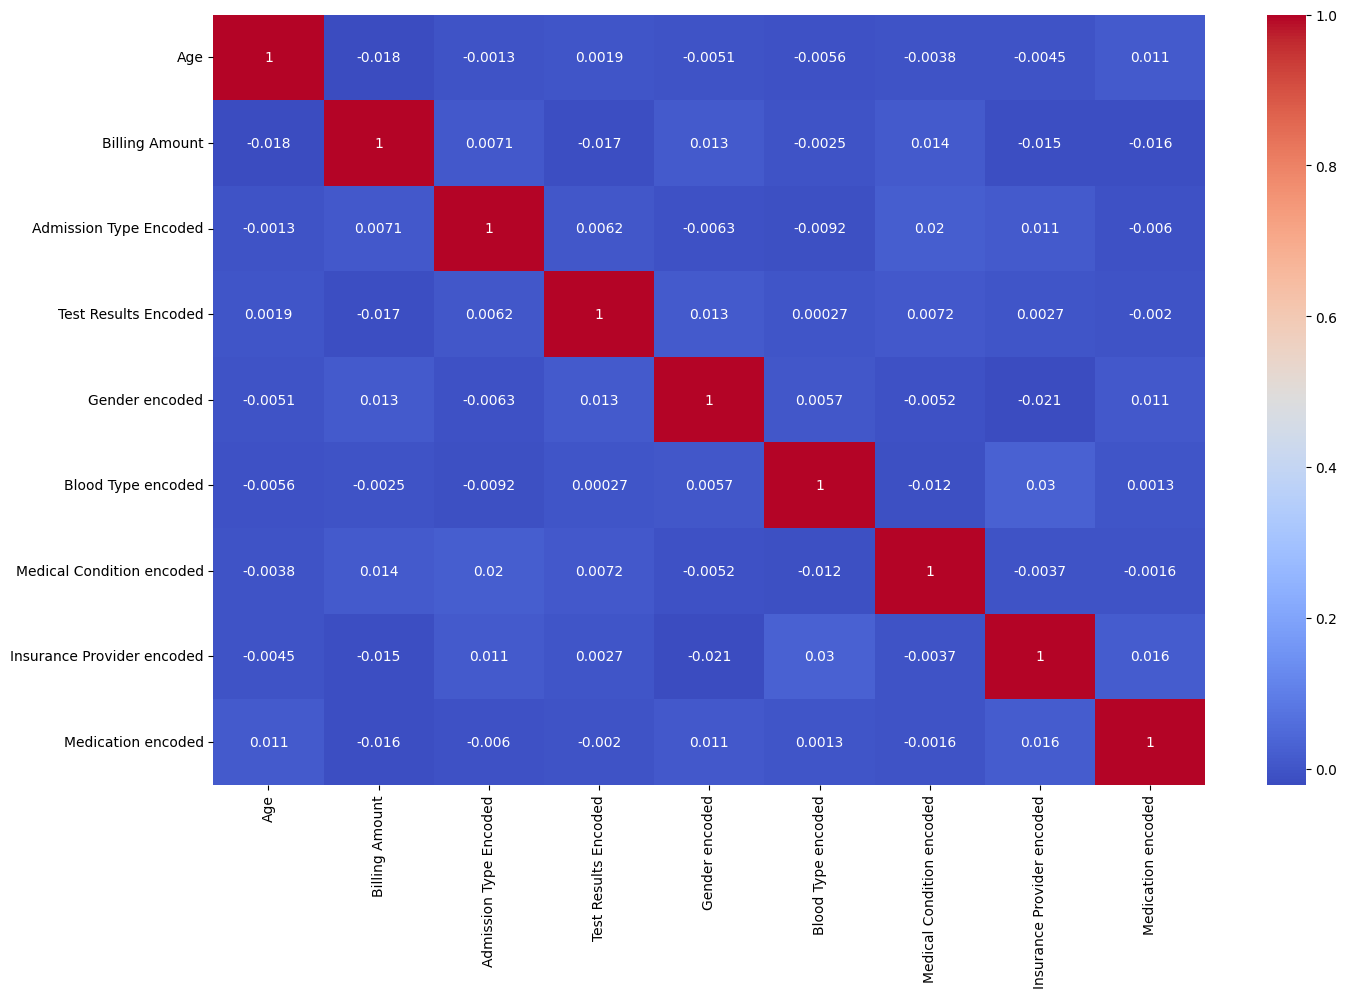

In [25]:
plt.figure(figsize=(16, 10))
sns.heatmap(train_data_preprocessed.corr(numeric_only=True), annot = True, cmap='coolwarm')
plt.show()

Very poor correlation between features

### Data Visualization

Try Linear Dimentionality Reduction like LDA

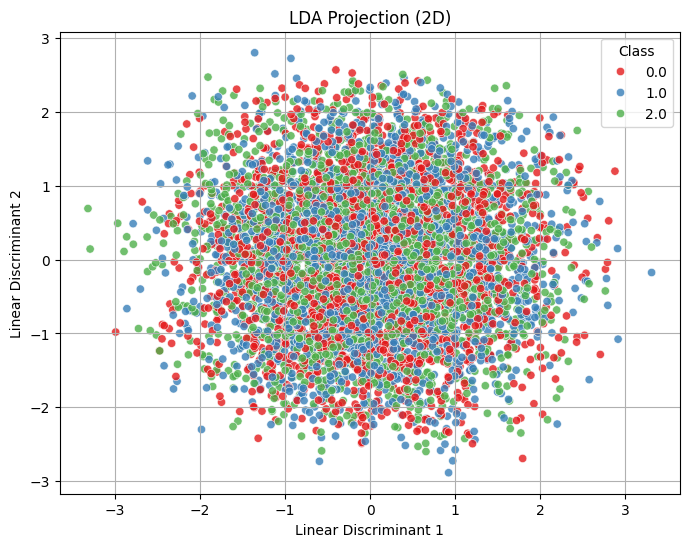

In [26]:
lda = LDA(n_components=2)
train_labels = train_data_preprocessed['Test Results Encoded']
X_lda = lda.fit_transform(train_data_preprocessed, train_labels)
lda_df = pd.DataFrame(X_lda, columns=['LD1', 'LD2'])
lda_df['class'] = train_labels

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x='LD1', y='LD2', hue='class', data=lda_df, palette='Set1', alpha=0.8)
plt.title('LDA Projection (2D)')
plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.legend(title='Class')
plt.grid(True)
plt.show()

Unable to separate classes because there is no linear relation between them. The classes are not linearly separable.

Try non linear dimensionality reduction techniques t-SNE

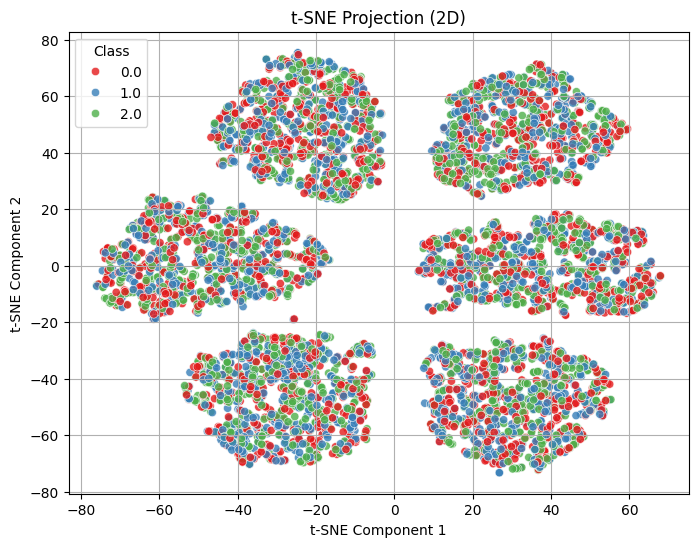

In [27]:
# Define target labels
train_labels = train_data_preprocessed['Test Results Encoded']

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(train_data_preprocessed.drop(columns=['Test Results Encoded']))  # Drop label column

# Convert to DataFrame
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['class'] = train_labels

# Plot using Seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='class', data=tsne_df, palette='Set1', alpha=0.8)
plt.title('t-SNE Projection (2D)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Class')
plt.grid(True)
plt.show()

### Dimentionality Reduction for Further Analysis

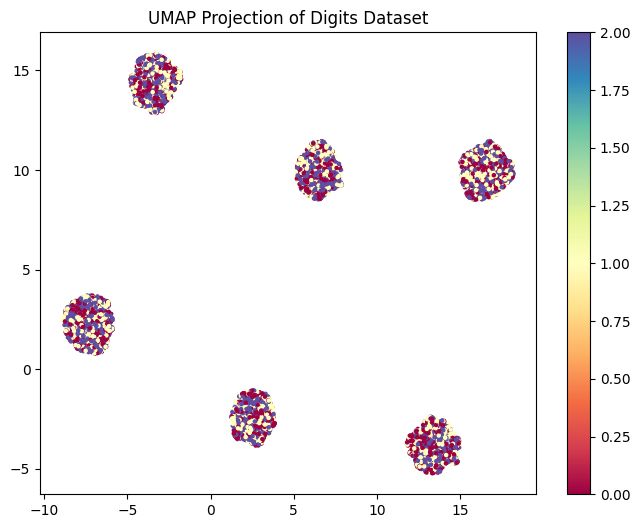

In [30]:
# Apply UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean')
embedding = reducer.fit_transform(train_data_preprocessed.drop(columns=['Test Results Encoded']))

# Plot results
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=train_data_preprocessed['Test Results Encoded'], cmap='Spectral', s=5)
plt.colorbar()
plt.title('UMAP Projection of Digits Dataset')
plt.show()

### Saving Datasets for Training Models

In [29]:
data_preprocessed.to_csv("Data_Preprocessed/preprocessed_data.csv", index=False)
train_data_preprocessed.to_csv("Data_Preprocessed/preprocessed_train.csv", index=False)
val_data_preprocessed.to_csv("Data_Preprocessed/preprocessed_val.csv", index=False)
test_data_preprocessed.to_csv("Data_Preprocessed/preprocessed_test.csv", index=False)